In [30]:
from BMX_Classes import *
import pandas as pd
import numpy as np
import pickle 

working_directory=u"/home/tyndall/20200309_Yale_BMX_Data/"
drone_directory=u'/hirax/rf_data/bnl_202003/drone_data/drone_20200312/'

## Pull list of BMX data files:
fileslist=np.sort(glob.glob('*.data'))
idstringlist=np.sort(list(set([fn.split('_yale_')[0] for i,fn in enumerate(fileslist)])))
os.chdir(working_directory)
    
## Pull list of processed drone csv files:
os.chdir(drone_directory)
drone_list=np.sort(glob.glob('*processed.csv'))

os.chdir(working_directory)

In [2]:
file= '/home/erk26/BMX/BMX_dicts/thurs_offsets.txt'
with open(file, 'rb') as handle:
    thurs_offsets = pickle.loads(handle.read())

## GPS Comparison


/home/erk26/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (117,118,119,120,121,122,123,124,125,126,292,392) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


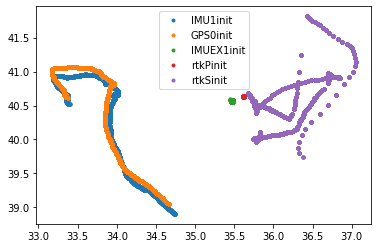

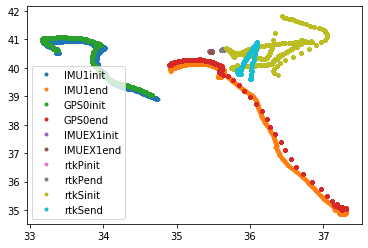

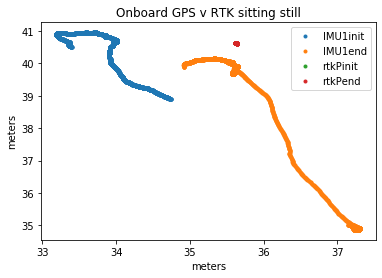

In [3]:
import pygeodesy
Origin_llh=VECT_BMX_E_LOC
prime_origin=pygeodesy.EcefCartesian(latlonh0=Origin_llh[0],\
                    lon0=Origin_llh[1],height0=Origin_llh[2],name='BMX_Tower_Center')

drone_data_df_full=pd.read_csv(drone_directory+'FLY351.csv')

def latlonconvert_testing(Latitude, Longitude):#     
    hmsl = drone_data_df_full['GPS(0):heightMSL']
    x = []
    y = []
    Lat = [i for i in list(Latitude) if i>10]
    Lon = [i for i in list(Longitude) if i<-10]
    for i in range(len(Lat)):
        p_t=pygeodesy.ellipsoidalNvector.LatLon(Lat[i],Lon[i],hmsl[i])
        coords_xyz_prime=prime_origin.forward(p_t).toVector() 
        x.append(coords_xyz_prime[0])
        y.append(coords_xyz_prime[1])
    return(x,y)

IMU1 = (e_IMU1, n_IMU1) = latlonconvert_testing(drone_data_df_full['IMU_ATTI(0):Latitude'], \
                             drone_data_df_full['IMU_ATTI(0):Longitude'])
GPS0 = (e_GPS0, n_GPS0) = latlonconvert_testing(drone_data_df_full['GPS(0):Lat'], \
                             drone_data_df_full['GPS(0):Long'])
IMUEX1 = e_IMUEX0, n_IMUEX0 = latlonconvert_testing(drone_data_df_full['IMUEX(0):rtk_Latitude'], \
                             drone_data_df_full['IMUEX(0):rtk_Longitude'])
rtkP = latlonconvert_testing(drone_data_df_full['RTKdata:Lat_P'], \
                             drone_data_df_full['RTKdata:Lon_P'])
rtkS = latlonconvert_testing(drone_data_df_full['RTKdata:Lat_S'], \
                             drone_data_df_full['RTKdata:Lon_S'])

gpstype = [IMU1, GPS0, IMUEX1, rtkP, rtkS]
gpslabel = ['IMU1', 'GPS0', 'IMUEX1', 'rtkP', 'rtkS']
for i in range(len(gpstype)):
    plt.plot(gpstype[i][0][500:6000], gpstype[i][1][500:6000], '.', label = gpslabel[i]+'init')
plt.legend()
plt.show()

for i in range(len(gpstype)):
    plt.plot(gpstype[i][0][500:6000], gpstype[i][1][500:6000], '.', label = gpslabel[i]+'init')
    plt.plot(gpstype[i][0][103600:-15], gpstype[i][1][103600:-15], '.', label = gpslabel[i]+'end')
plt.legend()
plt.show()

for i in [0, 3]:
    plt.plot(gpstype[i][0][500:6000], gpstype[i][1][500:6000], '.', label = gpslabel[i]+'init')
    plt.plot(gpstype[i][0][103600:-15], gpstype[i][1][103600:-15], '.', label = gpslabel[i]+'end')
plt.legend()
plt.xlabel('meters')
plt.ylabel('meters')
plt.title('Onboard GPS v RTK sitting still')
plt.show()




## RFI INVESTIGATION





In [4]:
flight_353 = Do_Everything_For_Data(drone_directory, file_organizer['Thursday'][9][0], working_directory, file_organizer['Thursday'][9][1])

DRONE CLASS initialized -- Loading Drone RTK Data from FLY353:
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
BMX_Data CLASS initialized -- Loading Telescope Data from 200312_2152:
  Constructing time array from header mjd:
  Constructing raw autocorrelation data array (dims=[2,4,freq,time]):


<Figure size 432x288 with 0 Axes>

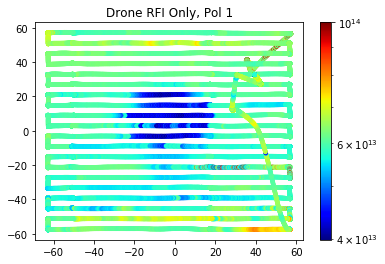

In [5]:
#looks like drone is shadowing sky
plt.scatter(flight_353.fulldict['x'],\
            flight_353.fulldict['y'], s=50,\
            c=(flight_353.fulldict['autos'][0,:,60]),\
            cmap='jet', vmax = 1e14, norm=LogNorm(), marker = '.')
plt.title('Drone RFI Only, Pol 1')
plt.colorbar()
plt.show()


In [6]:
beamCenters = ([-4.670897458296071, 7.777616712345406],\
[3.3385316030884016, -3.27205823116637],\
[3.2569049644387906, 1.2983814825634061],\
[-10.421877726648322, -0.7263793693162363])

In [7]:
from scipy import spatial

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array)):
        return array[idx-1]
    else:
        return array[idx]
    
def find_inx(array,value):
    idx = np.searchsorted(array, value, side="left")
    return(idx)

def find_inx2D(xarray,yarray,x,y):
    coordpairs = [(xarray[i], yarray[i]) for i in range(len(xarray))]
    tree = spatial.KDTree(coordpairs)
    idx = tree.query([(x,y)])[1]
    return(idx)

Text(0.5, 1.0, 'Drone RFI Illustration (Spectra with drone overhead, on ground)')

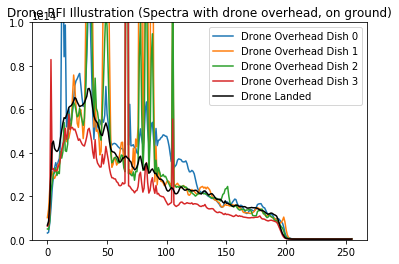

In [8]:
#this result looked different for pol 1 (drone more clearly shadowing telescope)
#but I don't have that data read in right now soooo

for i in range(4):
    overheadindx = find_inx2D(flight_353.fulldict['x'], flight_353.fulldict['y'], beamCenters[i][0], beamCenters[i][1])
    plt.plot(flight_353.fulldict['autos'][i,int(overheadindx),:], label = 'Drone Overhead Dish '+str(i))
plt.plot(flight_353.fulldict['autos'][i,len(flight_353.fulldict['autos'][0,:,0])-10,:], label = 'Drone Landed', color = 'black')

plt.legend()
plt.ylim(0,1e14)
plt.title('Drone RFI Illustration (Spectra with drone overhead, on ground)')


In [9]:
#old flight 304 had weird timestamp (months off) that was screwing up interpolation, so I deleted it and saved new file

# drone_304 = pd.read_csv(drone_directory+'FLY304_processed.csv')
# drone_304.drop(drone_304.tail(1).index,inplace=True)
# file = u'/hirax/rf_data/bnl_202003/drone_data/drone_20200309/FLY304_2_processed.csv'
# drone_304.to_csv(file, encoding='utf-8')

In [10]:
drone_directory=u'/hirax/rf_data/bnl_202003/drone_data/drone_20200309/'
flight_304 = Do_Everything_For_Data(drone_directory, 'FLY304_2', working_directory, file_organizer['Monday'][0][1])

DRONE CLASS initialized -- Loading Drone RTK Data from FLY304_2:
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
BMX_Data CLASS initialized -- Loading Telescope Data from 200309_1825:
  Constructing time array from header mjd:
  Constructing raw autocorrelation data array (dims=[2,4,freq,time]):


<Figure size 432x288 with 0 Axes>

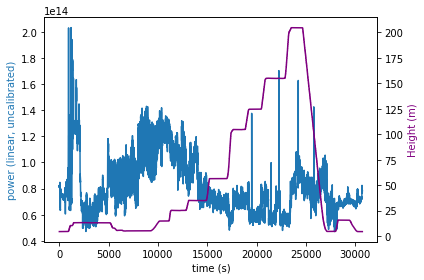

In [11]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('power (linear, uncalibrated)', color = color)
ax1.plot(flight_304.fulldict['autos'][0,:,50])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Height (m)', color='purple')  # we already handled the x-label with ax1
ax2.plot(flight_304.fulldict['z'], color = 'purple')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

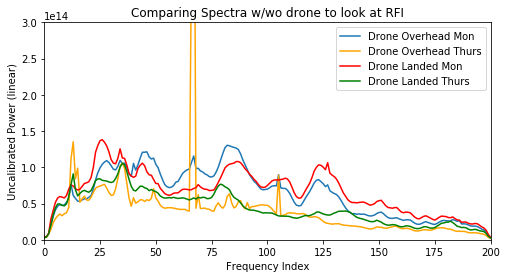

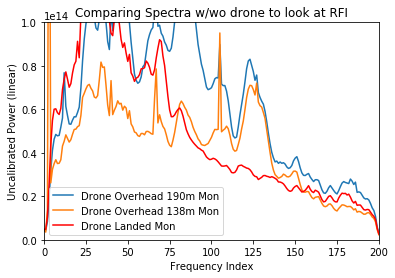

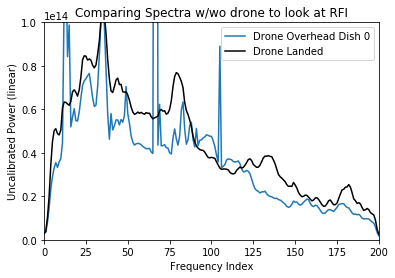

In [12]:
plt.figure(figsize = (8, 4))
overheadindx_thurs = find_inx2D(flight_353.fulldict['x'], flight_353.fulldict['y'], beamCenters[0][0], beamCenters[0][1])

plt.plot(flight_304.fulldict['autos'][0,24000,:], label = 'Drone Overhead Mon')
plt.plot(flight_353.fulldict['autos'][0,int(overheadindx_thurs),:], color = 'orange',label = 'Drone Overhead Thurs')
plt.plot(flight_304.fulldict['autos'][0,-1,:], color = 'red',label = 'Drone Landed Mon')
plt.plot(flight_353.fulldict['autos'][0,-1,:], color = 'green',label = 'Drone Landed Thurs')
# plt.plot(tel_353.autodata_raw[1, 0, 10789, :])
plt.legend()
plt.xlim(0,200)
plt.ylim(0,3e14)
plt.xlabel('Frequency Index')
plt.ylabel('Uncalibrated Power (linear)')
# plt.ylim(0,1e14)
plt.title('Comparing Spectra w/wo drone to look at RFI')
plt.show()

plt.plot(flight_304.fulldict['autos'][0,24000,:], label = 'Drone Overhead 190m Mon')
plt.plot(flight_304.fulldict['autos'][0,20000,:], label = 'Drone Overhead 138m Mon')

plt.plot(flight_304.fulldict['autos'][0,0,:], color = 'red',label = 'Drone Landed Mon')
# plt.plot(tel_353.autodata_raw[1, 0, 10789, :])
plt.legend()
plt.xlim(0,200)
plt.xlabel('Frequency Index')
plt.ylabel('Uncalibrated Power (linear)')
plt.ylim(0,1e14)
plt.title('Comparing Spectra w/wo drone to look at RFI')
plt.show()

overheadindx = find_inx2D(flight_353.fulldict['x'], flight_353.fulldict['y'], beamCenters[0][0], beamCenters[0][1])
plt.plot(flight_353.fulldict['autos'][0,int(overheadindx),:], label = 'Drone Overhead Dish 0')
plt.plot(flight_353.fulldict['autos'][0,len(flight_353.fulldict['autos'][0,:,0])-10,:], label = 'Drone Landed', color = 'black')
plt.legend()
plt.xlim(0,200)
plt.xlabel('Frequency Index')
plt.ylabel('Uncalibrated Power (linear)')
plt.ylim(0,1e14)
plt.title('Comparing Spectra w/wo drone to look at RFI')
plt.show()


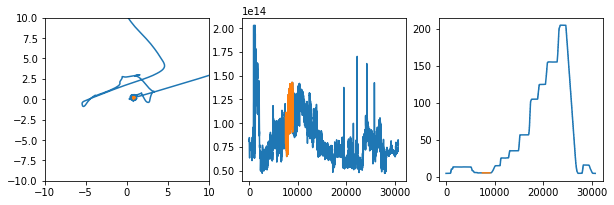

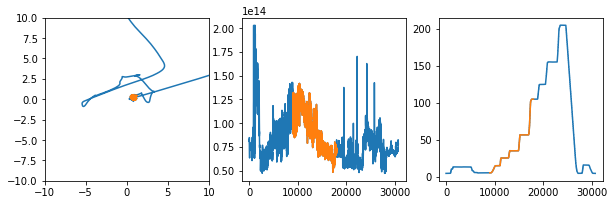

In [13]:
#figuring out which part of the spectrum corresponds to which changes in height

lb = 7500
ub = 9000

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(1,3,2)
ax.plot(flight_304.fulldict['autos'][0,:,50])
ax.plot(np.arange(lb,ub), flight_304.fulldict['autos'][0,:,50][lb:ub])
ax = fig.add_subplot(1,3,1)
ax.plot(flight_304.fulldict['x'], flight_304.fulldict['y'])
ax.plot(flight_304.fulldict['x'][lb:ub], flight_304.fulldict['y'][lb:ub])
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

ax = fig.add_subplot(1,3,3)
ax.plot(flight_304.fulldict['z'])
ax.plot(np.arange(lb,ub), flight_304.fulldict['z'][lb:ub])
plt.show()

lb = 9000
ub = 18000

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(1,3,2)
ax.plot(flight_304.fulldict['autos'][0,:,50])
ax.plot(np.arange(lb,ub), flight_304.fulldict['autos'][0,:,50][lb:ub])

ax = fig.add_subplot(1,3,1)
ax.plot(flight_304.fulldict['x'], flight_304.fulldict['y'])
ax.plot(flight_304.fulldict['x'][lb:ub], flight_304.fulldict['y'][lb:ub])
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

ax = fig.add_subplot(1,3,3)
ax.plot(flight_304.fulldict['z'])
ax.plot(np.arange(lb,ub), flight_304.fulldict['z'][lb:ub])

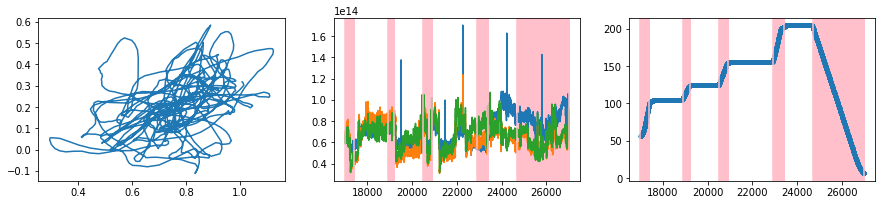

In [14]:
lb = 17000
ub = 27000
freq = 50
vlines = [17000, 17400, 18900, 19200, 20500, 20900, 22900, 23400 , 24700, 27000]


fig = plt.figure(figsize = (15,3))
ax = fig.add_subplot(1,3,2)
ax.plot(np.arange(lb,ub),flight_304.fulldict['autos'][0,:,freq][lb:ub])
ax.plot(np.arange(lb,ub),flight_304.fulldict['autos'][0,:,100][lb:ub])
ax.plot(np.arange(lb,ub),flight_304.fulldict['autos'][0,:,120][lb:ub])

for element in vlines: ax.axvline(element, color = 'pink')
for i in np.arange(0,len(vlines)-1,2): plt.axvspan(xmin = vlines[i], xmax = vlines[i+1],color = 'pink')

ax = fig.add_subplot(1,3,1)
ax.plot(flight_304.fulldict['x'][lb:ub], flight_304.fulldict['y'][lb:ub])


ax = fig.add_subplot(1,3,3)
ax.plot(np.arange(lb,ub),flight_304.fulldict['z'][lb:ub], '.')
for element in vlines: ax.axvline(element, color = 'pink')
for i in np.arange(0,len(vlines)-1,2): plt.axvspan(xmin = vlines[i], xmax = vlines[i+1],color = 'pink')


## Diode Removal
(much of this code lifted from an old nb of Anzes)

In [15]:
import bmxobs
d = bmxobs.BMXObs("/home/erk26/github_test_dir/200312_1732_yale","all_auto") ## specify what to load, we say all auto channels

In [16]:
d.diode_buf_samp = 2
d1 = d.remove_diode_pulses(to_self=False)

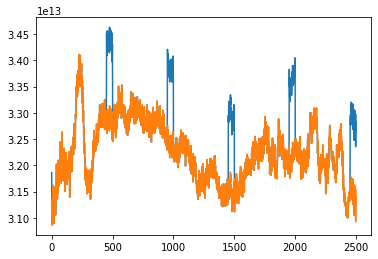

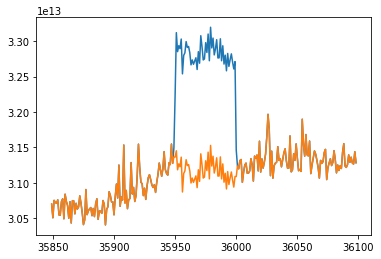

In [17]:
#compare diode with diode removed (no drone)

plt.plot(d[110][20500:23000, 100])
plt.plot(d1[110][20500:23000, 100])
plt.show()

#isolate a pulse
lb = 35949-100
ub = 35999+100
plt.plot(np.arange(lb, ub), d[110][lb:ub,100])
plt.plot(np.arange(lb, ub), d1[110][lb:ub,100])

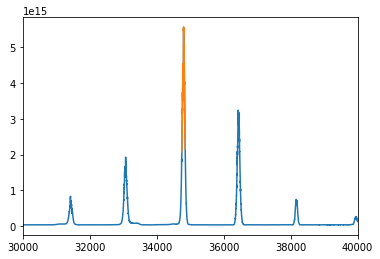

Text(0.5, 1.0, 'diode and diode removed, unprocessed data with anzes analysis')

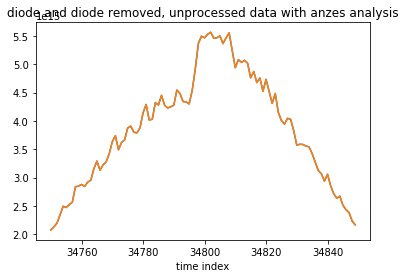

In [18]:
lb = 34750
ub = 34850

plt.plot(d[110][:, 100])
# plt.plot(np.arange(lb, ub), d[110][lb:ub, 100])
plt.plot(np.arange(lb, ub), d1[110][lb:ub, 100])
plt.xlim(30000,40000)
plt.show()

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100])
plt.plot(np.arange(lb, ub), d1[110][lb:ub, 100])
plt.xlabel('time index')
plt.title('diode and diode removed, unprocessed data with anzes analysis')

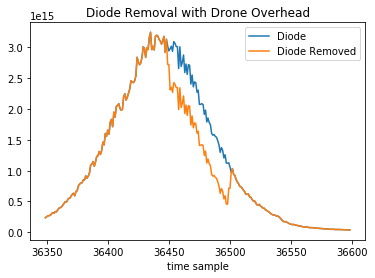

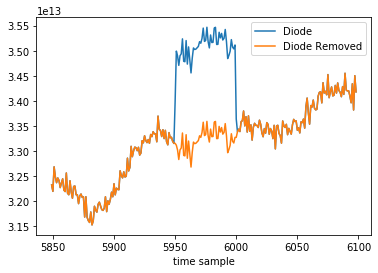

In [19]:
# plt.plot(np.arange(930,1100), d[110][930:1100, 100])
# plt.plot(np.arange(930,1100), d1[110][930:1100, 100])

lb = d.diode_pulses()[71][0]-100
ub = d.diode_pulses()[71][1]+100

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100], label = 'Diode')
plt.plot(np.arange(lb, ub), d1[110][lb:ub, 100], label = 'Diode Removed')
plt.legend()
plt.xlabel('time sample')
plt.title('Diode Removal with Drone Overhead')
plt.show()

lb = d.diode_pulses()[10][0]-100
ub = d.diode_pulses()[10][1]+100

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100], label = 'Diode')
plt.plot(np.arange(lb, ub), d1[110][lb:ub, 100], label = 'Diode Removed')
plt.legend()
plt.xlabel('time sample')
# plt.title('Diode Removal with Drone Overhead')
plt.show()

#might do some weird stuff

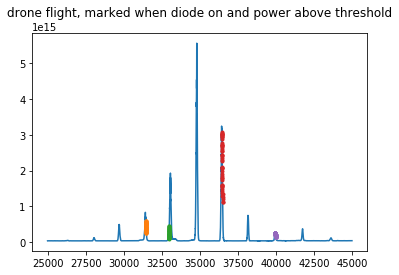

In [20]:
lb= 25000
ub = 45000
timeranges_of_interest = []

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100])
for i in range(55, 80): 
    lb2, ub2 = d.diode_pulses()[i]
    if d[110][lb2:ub2, 100].max() > 1e14:
        plt.plot(np.arange(lb2, ub2), d[110][lb2:ub2, 100], '.')
        timeranges_of_interest.append(i)
plt.title('drone flight, marked when diode on and power above threshold', y = 1.05)
plt.show()


Text(0.5, 0.93, 'Diode Removal with Drone Overhead')

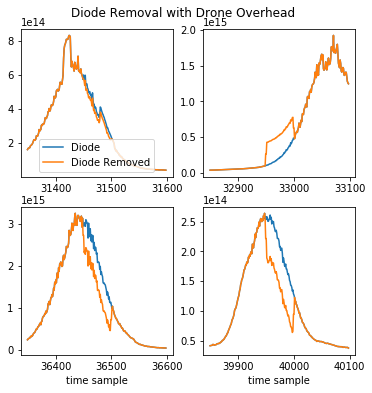

In [21]:
#clearly ineffective

fig = plt.figure(figsize = (6,6))
counter = 0
for i in timeranges_of_interest:
    lb = d.diode_pulses()[i][0]-100
    ub = d.diode_pulses()[i][1]+100
    
    ax = fig.add_subplot(2,2,counter+1)

    ax.plot(np.arange(lb, ub), d[110][lb:ub, 100], label = 'Diode')
    ax.plot(np.arange(lb, ub), d1[110][lb:ub, 100], label = 'Diode Removed')
    if counter == 2 or counter == 3:
        ax.set_xlabel('time sample')
    
    if i == timeranges_of_interest[0]:
        ax.legend(loc = 'lower center')


#     plt.show()
    counter+=1
plt.suptitle('Diode Removal with Drone Overhead', y = 0.93)

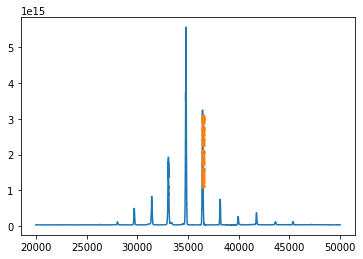

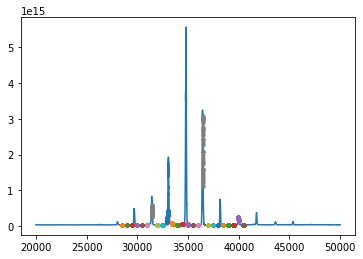

In [22]:
lb = 20000
ub = 50000

lb2, ub2 = d.diode_pulses()[71]

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100])
plt.plot(np.arange(lb2, ub2), d[110][lb2:ub2, 100], '.')

plt.show()

plt.plot(np.arange(lb, ub), d[110][lb:ub, 100])
for i in range(55, 80): 
    lb2, ub2 = d.diode_pulses()[i]
    plt.plot(np.arange(lb2, ub2), d[110][lb2:ub2, 100], '.')



## Tagging Overlapping Points, and Comparing Power

In [23]:
from scipy import spatial

def overlapingpoints(flight1,flight2):
    coords1_x = flight1.fulldict['x']
    coords1_y = flight1.fulldict['y']
    coords1 = np.array([coords1_x,coords1_y])
    coords1 = coords1.transpose()
    coords1 = [(round(coords1[i][0],1),round(coords1[i][1],1)) for i in range(len(coords1))]

    coords2_x = flight2.fulldict['x']
    coords2_y = flight2.fulldict['y']
    coords2 = np.array([coords2_x,coords2_y])
    coords2 = coords2.transpose()
    coords2 = [(round(coords2[i][0],1),round(coords2[i][1],1)) for i in range(len(coords2))]

    intersection_set = set.intersection(set(coords1), set(coords2))
    intersection_list = list(intersection_set)
    
    points = np.array(intersection_list)
    points = points.transpose()
    return(points)


def find_inx2D(flightdict,points):
#     xarray, yarray = flightdict.fulldict['x'],flightdict.fulldict['y']
    xarray = [round(flightdict.fulldict['x'][i],1) for i in range(len(flightdict.fulldict['x']))]
    yarray = [round(flightdict.fulldict['y'][i],1) for i in range(len(flightdict.fulldict['y']))]
    
    sys.setrecursionlimit(20000)

    x = points[0]
    y = points[1]
    coordpairs = [(xarray[i], yarray[i]) for i in range(len(xarray))]
    tree = spatial.KDTree(coordpairs)
    indeces = []
    for j in range(len(x)):
        idx = tree.query([(x[j],y[j])])[1]
        indeces.append(idx)
    return(indeces)

In [24]:
#get incedes for two flights where points match up and corresponding powers at those indeces

points344 = overlapingpoints(thurs_offsets['FLY344'],thurs_offsets['FLY347'])
points347 = overlapingpoints(thurs_offsets['FLY347'],thurs_offsets['FLY344'])

common_indeces344 = find_inx2D(thurs_offsets['FLY344'], points344)
common_indeces347 = find_inx2D(thurs_offsets['FLY347'], points347)

power344= [thurs_offsets['FLY344'].fulldict['autos'][0][[common_indeces344[i][0]],100][0] for i in range(len(common_indeces344))]
power347= [thurs_offsets['FLY347'].fulldict['autos'][0][[common_indeces347[i][0]],100][0] for i in range(len(common_indeces347))]


In [25]:
xpoints344 = [thurs_offsets['FLY344'].fulldict['x'][common_indeces344[i][0]] for i in range(len(common_indeces344))]
ypoints344 = [thurs_offsets['FLY344'].fulldict['y'][common_indeces344[i][0]] for i in range(len(common_indeces344))]

xpoints347 = [thurs_offsets['FLY347'].fulldict['x'][common_indeces347[i][0]] for i in range(len(common_indeces347))]
ypoints347 = [thurs_offsets['FLY347'].fulldict['y'][common_indeces347[i][0]] for i in range(len(common_indeces347))]

coords344 = [(round(xpoints344[i],1), round(ypoints344[i],1)) for i in range(len(xpoints344))]
df344 = pd.DataFrame({"coords":coords344, "power":power344})

coords347 = [(round(xpoints347[i],1), round(ypoints347[i],1)) for i in range(len(xpoints347))]
df347 = pd.DataFrame({"coords":coords347, "power":power347})

df_344_347 = pd.concat([df344,df347])
df_344_347.sort_values(by = 'coords')
test_df = df_344_347.sort_values(by = 'coords')
test_df = test_df.reset_index()

In [26]:
difference = []
common_coords = []
for i in np.arange(0,len(test_df),2):
    diff = test_df['power'][i+1]-test_df['power'][i]
    difference.append(diff)
    common_coords.append(test_df['coords'][i])
    
percentdifference = []
for i in np.arange(0,len(test_df),2):
    diff = (test_df['power'][i+1]-test_df['power'][i])/test_df['power'][i]
    percentdifference.append(diff)


In [27]:
intersection_set = set.intersection(set(coords344), set(coords347))
intersection_list = list(intersection_set)

points = np.array(intersection_list)
points.transpose()
test = points.transpose()

Text(0, 0.5, 'Meters')

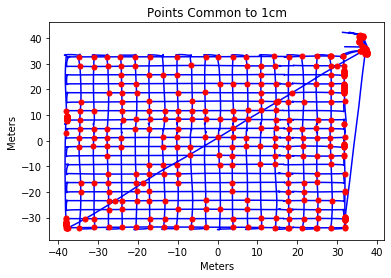

In [28]:
plt.plot(thurs_offsets['FLY344'].fulldict['x'],thurs_offsets['FLY344'].fulldict['y'], 'b')
plt.plot(thurs_offsets['FLY347'].fulldict['x'],thurs_offsets['FLY347'].fulldict['y'], 'b')
plt.plot(test[0],test[1], '.', color = 'red', markersize = 10)
plt.title('Points Common to 1cm')
plt.xlabel('Meters')
plt.ylabel('Meters')

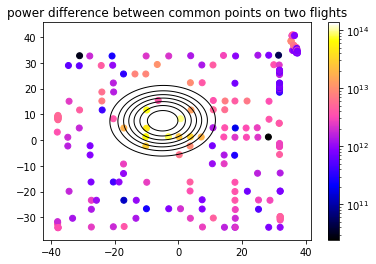

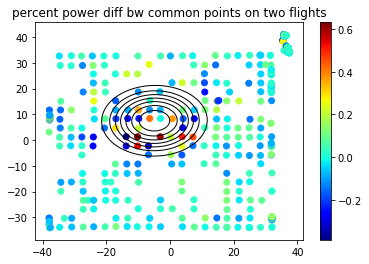

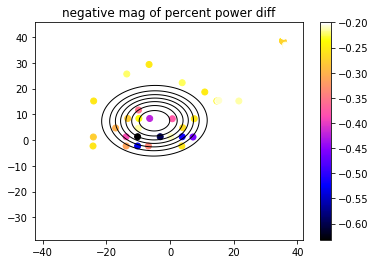

In [29]:
#formatted the last plot as negative so points i didnt want to visualize would turn white 
#(theres obviously a better way to exclude points, im just tired)

x = thurs_offsets['FLY347'].fulldict['x']
y = thurs_offsets['FLY347'].fulldict['y']
z = thurs_offsets['FLY347'].fulldict['autos'][0][:,100]

initial_guess = (1e15, 8, 0, 5, 5, 0, 100)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)


x = np.linspace(-30, 30, 200)
y = np.linspace(-30, 30, 200)
x, y = np.meshgrid(x, y)

data = twoD_Gaussian((x, y), *popt)

plt.contour(x,y, np.log10(data.reshape(200,200)), extent = [-30 , 30, -30 , 30], colors='black', linewidths = 1)
plt.scatter(np.array(common_coords).transpose()[0], np.array(common_coords).transpose()[1], c = difference, cmap = 'gnuplot2', norm = LogNorm())
plt.title("power difference between common points on two flights")
plt.colorbar()
plt.show()


plt.contour(x,y, np.log10(data.reshape(200,200)), extent = [-30 , 30, -30 , 30], colors='black', linewidths = 1)
plt.scatter(np.array(common_coords).transpose()[0], np.array(common_coords).transpose()[1], c = percentdifference, cmap = 'jet')
plt.title("percent power diff bw common points on two flights")
plt.colorbar()
plt.show()

plt.contour(x,y, np.log10(data.reshape(200,200)), extent = [-30 , 30, -30 , 30], colors='black', linewidths = 1)
plt.scatter(np.array(common_coords).transpose()[0], np.array(common_coords).transpose()[1], c = -np.abs(percentdifference), vmax = -0.2, cmap = 'gnuplot2')
plt.title("negative mag of percent power diff")
plt.colorbar()
plt.show()